In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from urllib.request import urlopen
from bs4 import BeautifulSoup

# Explorando políticos y relaciones

La idea es explorar los datos disponibles en la página del congreso para
- Conocer la información disponible
- Recopilar la info relevante

Son páginas distintas para [senadores](http://www.senado.cl/) y [diputados](http://www.camara.cl/)


La dataframe ``df_senators`` tiene la info consolidad que se le va adicionando según se colecciona nueva info

## TODO

- [ ] Normalizar spanglish (dificil por los elementos en español)


## Senadores
- [X] [listado de senadores con datos de partidos](#listado-de-senadores)

Asistencia y gastos
- [X] [asistencia a sala](#Asistencia-a-sala)
- [X] [asistencia a comisiones permanentes](#Asistencia-a-comisiones-permanentes)
- [X] [gastos en personal de apoyo](#Personal-de-apoyo)
- [ ] [asesorias externas](#Asesorias-externas)

Votaciones
- [ ] el [partidopirata.cl](https://www.partidopirata.cl/explorando-datos-de-la-camara-de-diputados-de-chile-manzana-mecanica/) tiene un análisis con las *distancias* entre diputados 


- [transparencia senado](http://www.senado.cl/senado/site/edic/base/port/transparencia_2017.html)

In [ ]:
def get_soup(url):
    html = urlopen(url)
    data = html.read().decode('utf-8')
    soup = BeautifulSoup(data, 'lxml')
    return soup
    

# Senadores

## listado de senadores

In [27]:
soup = get_soup(("http://www.senado.cl/appsenado/index.php?mo=senadores&ac=listado"))

In [28]:
soup_senators = soup.find_all('td', {'class': 'clase_td'})

In [29]:
# son pocos senadores (por suerte) asi que me tomo una licencia con los O(n2)
senators_rows = []
senator_row = []
for item in soup_senators:
    if len(item.contents) == 10:
        for i in [0, 3, 5, 8]:
            senator_row.append(item.contents[i].string.strip())
            
    elif len(item.contents) == 2:
        p = item.contents[1]            
        senator_row.append(p.string)
        senators_rows.append(senator_row)
        senator_row = []
        
df_senators = pd.DataFrame(senators_rows, columns=['nombre', 'región', 'circunscripción', 'email', 'partido'])

## Asistencia a sala

### TODO 
- [ ] legiini=361&legiid=490 indican la legislatura 317 (11/03/2019-10/03/2020). Para scrapear todas hay que ver las legislaturas

In [30]:

soup_sala = get_soup('http://www.senado.cl/appsenado/index.php?mo=sesionessala&ac=asistenciaSenadores&camara=S&legiini=361&legiid=490')

l_sala = soup_sala.find_all('tr', {'align': 'left'})

l_asistencia = [] 
f = lambda i, index : i.contents[index].string.strip()

#*****************************************
# TODO refactor this awful thing
#*****************************************
# for each tr find its td
for item in l_sala: 
    a = item.find_all('td')
    index = 0
    asistencia = []
    for i in a: # reviewing tag
        if index == 0:
            asistencia.append(f(i, 0))
        elif index == 1:
            asistencia.append(f(i, 1))
        elif index == 2:
            asistencia.append(i.contents[1].string)
        index = index + 1    
    if len(asistencia) > 0:
        l_asistencia.append(asistencia)
df_asistencia = pd.DataFrame(l_asistencia, columns=['nombre', 'asistencias', 'inasistencias justificadas'])


In [31]:
# Total de sesiones
ses = soup_sala.find('h2', {'class': 'serif'})
sesiones = [int(i) for i in ses.string.split() if i.isdigit()]
print('total de sesiones', sesiones)

total de sesiones [107]


In [33]:
df_asistencia.fillna(value=0, inplace=True)
for key in ['asistencias', 'inasistencias justificadas']:
    df_asistencia[key] = pd.to_numeric(df_asistencia[key])
df_asistencia['inasistencias'] = sesiones - df_asistencia['asistencias']

In [34]:
assert len(df_asistencia) == 43, 'Son 43 senadores actuales'

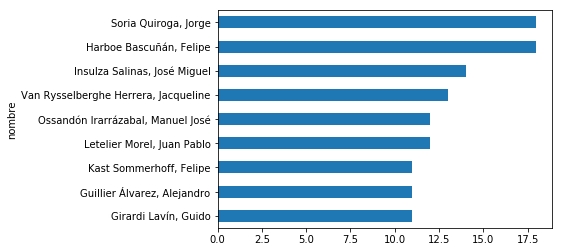

In [36]:
df_senators = pd.merge(df_senators, df_asistencia)
df_senators.set_index('nombre', inplace=True)
df_senators[df_senators.inasistencias > 10].sort_values(by='inasistencias').inasistencias.plot(kind='barh')

## asistencia a sala por partido

In [11]:
df_senators.groupby(['partido']).sum()

,asistencias,inasistencias justificadas,inasistencias
partido,,,
Evopoli,84,9,11
Independiente,532,12,38
P.D.C.,448,12,27
P.P.D.,516,15,54
P.S.,597,49,68
Pais Progresista,74,0,21
R.N.,630,12,35
Revolución Democrática,90,3,5
U.D.I.,787,25,68


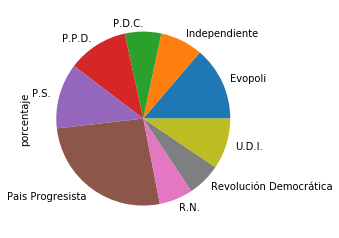

In [12]:
#se define un % de inasistencia sobre el total (suma de asistencias + inasistencias)
df_partidos_asistencia = df_senators.groupby(['partido']).sum()
df_partidos_asistencia['porcentaje'] = (df_partidos_asistencia.inasistencias / (df_partidos_asistencia.inasistencias + df_partidos_asistencia.asistencias) * 100)
df_partidos_asistencia.porcentaje.plot(kind='pie')

## Asistencia a comisiones permanentes
Sobre las comisiones permanentes:  https://www.bcn.cl/formacioncivica/detalle_guia?h=10221.3/45759

In [13]:
soup_comisiones = get_soup('http://www.senado.cl/appsenado/index.php?mo=comisiones&ac=asist_x_senador&idsenador=0&ano=2019')

In [14]:
# recolectando id de senador usado en el selector de senadores para pedir la info individual
select_senadores = soup_comisiones.find('select', {'name': 'sel_senador'})
l_asistencia_comisiones = []
for child in select_senadores.findChildren():
    tuple = [child.string, child.attrs['value']]
    l_asistencia_comisiones.append(tuple)
l_asistencia_comisiones
df_asistencia_comisiones = pd.DataFrame(l_asistencia_comisiones, columns=['nombre', 'id_interno'])
df_asistencia_comisiones['id_interno'] = pd.to_numeric(df_asistencia_comisiones['id_interno'])
df_asistencia_comisiones = df_asistencia_comisiones[df_asistencia_comisiones.id_interno > 0]

In [15]:
# quizas se deba normalizar los nombres, por el momento, solo strip
df_senators.index = df_senators.index.str.strip()
df_asistencia_comisiones.nombre = df_asistencia_comisiones.nombre.str.strip()

In [16]:
# acá el df tiene la info básica y los id de cada senador
df_senators = pd.merge(df_senators, df_asistencia_comisiones, on='nombre')
assert len(df_senators) == 43, 'Se deben mantener 43 senadores después del merge con la asistencia a comisiones'

In [17]:
def procesar_asistencia_comision(soup):
    tds = soup.find_all('td', {'align': {'center'}})
    index = 0
    rows = []
    row = []
    for td in tds:
        row.append(td.string)
        if index == 2:
            rows.append(row)
            row = []
            index = 0
        else:
            index = index + 1
    return rows

soup_columns_comisiones = ['sesiones', 'asistencia', 'justificadas']

lista_senadores = []

# info de cada senadores y sus comisiones usando el id para obtener el soup
for senador_id in df_senators['id_interno']:
    #print('buscando a ', senador_id)
    soup_tmp = get_soup('http://www.senado.cl/appsenado/index.php?mo=comisiones&ac=asist_x_senador&idsenador={}&ano=2019'.format(senador_id))
    rows = procesar_asistencia_comision(soup_tmp)

    df_senador = pd.DataFrame(rows, columns=soup_columns_comisiones)
    
    for column in soup_columns_comisiones:
        df_senador[column] = pd.to_numeric(df_senador[column])
    df_senador['inasistencia'] = df_senador['sesiones'] - df_senador['asistencia']

    #hay errores en la cantidad de sesiones que hace inasistencias negativas, so..
    df_senador.loc[(df_senador['inasistencia'] < 0)] = 0
    #print(df_senador)
    
    # guardamos la cantidad de sesiones y la inasistencia para sacar el %
    l = [df_senador.sesiones.sum(), df_senador.inasistencia.sum(), senador_id]
    lista_senadores.append(l)
    #print('==========')


In [18]:
# la suma de la sesiones de las comisiones y las inasistencias
df_senadores_total = pd.DataFrame(lista_senadores, columns=['sesiones_comisiones', 'inasistencias_comisiones', 'id_interno'])

# la cantidad de sesiones de cada uno es variable, para normalizar uso el % de inasistencia
df_senadores_total['inasistencia_comisiones_porc'] = df_senadores_total.inasistencias_comisiones / (df_senadores_total.sesiones_comisiones) * 100
df_senadores_total.head()

,sesiones_comisiones,inasistencias_comisiones,id_interno,inasistencia_comisiones_porc
0,150,21,905,14.000000
1,192,65,985,33.854167
2,187,22,1221,11.764706
3,95,19,1110,20.000000
4,154,36,907,23.376623


In [19]:
df_senators = pd.merge(df_senators, df_senadores_total, on='id_interno')
# después del merge, el index se pierde, so...
df_senators.set_index('nombre', inplace=True)
df_senators

,región,circunscripción,email,partido,asistencias,inasistencias justificadas,inasistencias,id_interno,sesiones_comisiones,inasistencias_comisiones,inasistencia_comisiones_porc
nombre,,,,,,,,,,,
"Allamand Zavala, Andrés",Región Metropolitana de Santiago,7,allamand@senado.cl,R.N.,85,4,10,905,150,21,14.000000
"Allende Bussi, Isabel",Región de Valparaíso,6,iallende@senado.cl,P.S.,70,26,25,985,192,65,33.854167
"Aravena Acuña, Carmen Gloria",Región de la Araucanía,11,cgloriaaravena@senado.cl,Independiente,89,0,6,1221,187,22,11.764706
"Araya Guerrero, Pedro",Región de Antofagasta,3,paraya@senado.cl,Independiente,79,12,16,1110,95,19,20.000000
"Bianchi Chelech, Carlos",Región de Magallanes y la Antártica Chilena,15,cbianchi@senado.cl,Independiente,94,0,1,907,154,36,23.376623
"Castro Prieto, Juan",Región del Maule,9,jcastro@senado.cl,R.N.,87,0,8,1218,122,23,18.852459
"Chahuán Chahuán, Francisco",Región de Valparaíso,6,fchahuan@senado.cl,R.N.,92,3,3,986,150,21,14.000000
"Coloma Correa, Juan Antonio",Región del Maule,9,jcoloma@senado.cl,U.D.I.,90,5,5,687,135,17,12.592593
"De Urresti Longton, Alfonso",Región de Los Ríos,12,adeurresti@senado.cl,P.S.,88,6,7,1115,182,34,18.681319


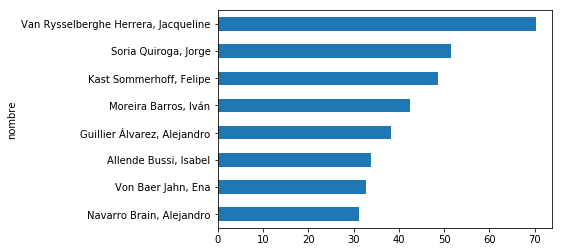

In [20]:
df_senators[df_senators.inasistencia_comisiones_porc > 30].sort_values(by='inasistencia_comisiones_porc').inasistencia_comisiones_porc.plot(kind='barh')

# Personal de apoyo

``df_personal`` **NO** está mezclado con ``df_senators``

son parecidos todos los meses, así que con 1 de muestra basta por ahora



In [47]:
year = '2019'
month = '12'
soup_personal = get_soup('http://www.senado.cl/appsenado/index.php?mo=transparencia&ac=informeTransparencia&tipo=15&anno=' + year + '&mesid=' + month)
l_personal = soup_personal.find_all('h1')
lista_personal = []
i_personal = []
for personal in l_personal:
    asignaciones = soup_personal.find('table', {'id': personal.string})
    asignaciones = asignaciones.find_all('tr')
    for asignacion in asignaciones:
        tds = asignacion.find_all('td')
        
        for td in tds:
            if td.string:
                i_personal.append(td.string)
        if tds:
            i_personal.append(personal.string)
            lista_personal.append(i_personal)
            i_personal = []

In [48]:
df_personal = pd.DataFrame(lista_personal, columns=['nombre', 'funcion', 'c. juridico', 'sueldo', 'senador', 'basura'])
df_personal.drop(columns=['basura'], inplace=True)

In [46]:
# Sueldos mas altos
key = 'sueldo'
df_personal[key] = df_personal[key].replace({',': ''}, regex=True)
df_personal[key] = pd.to_numeric(df_personal[key])
df_personal.sort_values(by=key, ascending=[False])

,nombre,funcion,c. juridico,sueldo,senador
2,"FUENTES BARROS, TOMAS ANDRES",ASESOR PARLAMENTARIO,INDEFINIDO,5900000,ALLAMAND ZAVALA ANDRES
209,"SOLER GARRIDO, ENRIQUE FRANCISCO JOSE",JEFE (A) DE GABINETE,INDEFINIDO,4773938,GUILLIER ALVAREZ ALEJANDRO
456,"FRITES LOPEZ, JORGE",JEFE (A) DE GABINETE,INDEFINIDO,4600150,QUINTEROS LARA RABINDRANATH
140,"MADARIAGA NORAMBUENA, CAMILA ESTEFANI",ASESOR (A) LEGISLATIVO,INDEFINIDO,4471062,GALILEA VIAL RODRIGO
416,"MORALES NAVEA, DANIELA CAROLINA",JEFE (A) DE GABINETE,INDEFINIDO,4355313,PROHENS ESPINOSA RAFAEL
500,"MORAN ESPINOZA, MARCELO ENRIQUE",JEFE DE GABINETE,HONORARIOS,4215063,VON BAER JAHN ENA
499,"MORAN ESPINOZA, MARCELO ENRIQUE",JEFE DE GABINETE,HONORARIOS,4215063,VON BAER JAHN ENA
1,"BASTIAS OPAZO, ROCIO DEL PILAR",ASESOR (A) POLITICO,INDEFINIDO,3900000,ALLAMAND ZAVALA ANDRES
391,"KING SUAU, MARIA PAZ",APOYO ADMINISTRATIVO,INDEFINIDO,3814801,CASTRO PRIETO JUAN
397,"LAMA BENAVIDES, HERNAN MANUEL",COORDINADOR (A) TERRITORIAL,INDEFINIDO,3754463,PEREZ VARELA VICTOR


# Asesorias externas
La asignacion mensual asciende a $ 3.435.444. Es acumulable en forma bimensual hasta el mes de Octubre.

In [54]:
b_year = '2019'
b_month = '12'
soup_asesorias = get_soup('http://www.senado.cl/appsenado/index.php?mo=transparencia&ac=informeTransparencia&tipo=16&anno=' + b_year + '&mesid=' + b_month)

In [71]:
def procesar_filas(filas, size):
    i = int(len(filas)/size)
    res = []
    for index in range(i):
        start = index*size
        end = (index*size+size)-1
        fila = filas[start:end]
        
        try:
            j = {'asesor': fila[0].contents[0].replace(',', ''), 
                 'materia': fila[1].contents[0],
                 'sueldo': fila[2].contents[0]}

            res.append(j)
        except Exception as exc:
            #print(fila)
            #print('-----------------------------------------')
            pass
        
    return res

    
def extraer_info_tabla(table, size=7):
    tds = table.select('tr td')
    res = procesar_filas(tds, size)
    return res

def procesar_senador(table, senador):
    rows = extraer_info_tabla(table)
    c = pd.DataFrame(rows)
    c['senador'] = senador
    return c

In [73]:
# h1 tiene los nombres que se usan como id en las tablas
id_list = soup_asesorias.find_all('h1')
df_asesorias_externas = pd.DataFrame(columns=['asesor', 'materia', 'sueldo', 'senador'])
for h1 in id_list:
    table = soup_asesorias.find('table', {'id': h1.string})
    c = procesar_senador(table, h1.string)
    df_asesorias_externas = pd.concat([df_asesorias_externas, c])
    
print(len(df_asesorias_externas))
print(df_asesorias_externas.asesor.nunique())
df_asesorias_externas

80
41


,asesor,materia,sueldo,senador
0,PINTO ROTH IGNACIO ANDRES,ASESORIA COMUNICACIONALES Y POILITICAS ANDRES ...,"2,888,889",ALLAMAND ZAVALA ANDRES
1,\n,"PINTO ROTH, IGNACIO ANDRES",ASESORIA COMUNICACIONALES Y POILITICAS ANDRES ...,ALLAMAND ZAVALA ANDRES
0,FERRADA HENRIQUEZ RAFAEL ALEJANDRO,ASESORIA MES DE NOVIEMBRE SENADOR ALLENDE ANTI...,"3,090,000",ALLENDE BUSSI ISABEL
1,\n,"FERRADA HENRIQUEZ, RAFAEL ALEJANDRO",ASESORIA MES DE NOVIEMBRE SENADOR ALLENDE ANTI...,ALLENDE BUSSI ISABEL
0,BASTIAS MILLANAO MARITZA ANDREA,SERVICIOS HONORARIOS MES NOVIEMBRE A LA SENADO...,"1,000,000",ARAVENA ACUNA CARMEN
1,\n,"BASTIAS MILLANAO, MARITZA ANDREA",SERVICIOS HONORARIOS MES NOVIEMBRE A LA SENADO...,ARAVENA ACUNA CARMEN
0,DAZA CARRASCO MAURICIO ANTONIO,DICIEMBRE 2019 ASESORIAS LEGISLATIVA PROCEDIMI...,"3,400,000",BIANCHI CHELECH CARLOS
1,\n,"DAZA CARRASCO, MAURICIO ANTONIO",DICIEMBRE 2019 ASESORIAS LEGISLATIVA PROCEDIMI...,BIANCHI CHELECH CARLOS
0,TORRES IBARRA DANTE ESTEBAN,ASESORIA COMUNICACIONAL Y DE PRENSA DEL SENADO...,"3,538,507",CASTRO PRIETO JUAN
1,\n,"TORRES IBARRA, DANTE ESTEBAN",ASESORIA COMUNICACIONAL Y DE PRENSA DEL SENADO...,CASTRO PRIETO JUAN
